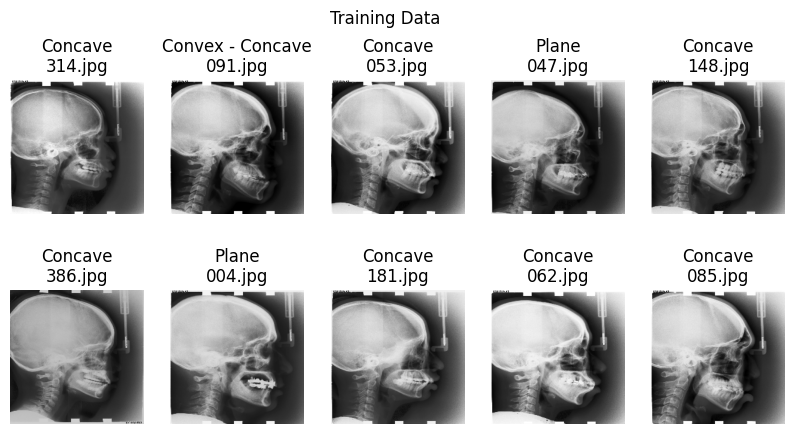

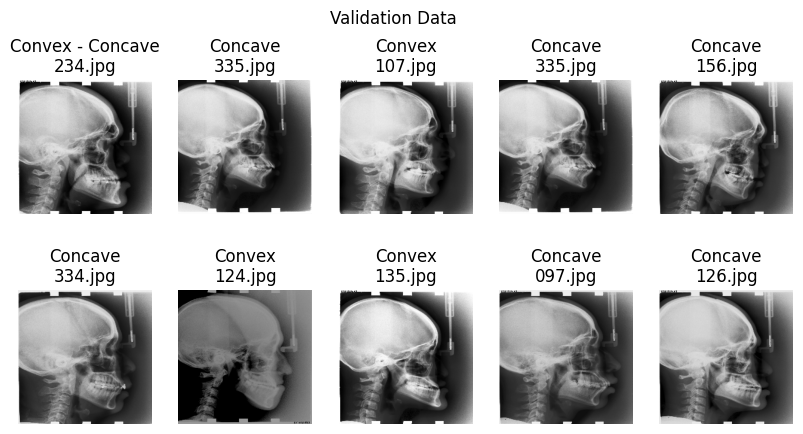

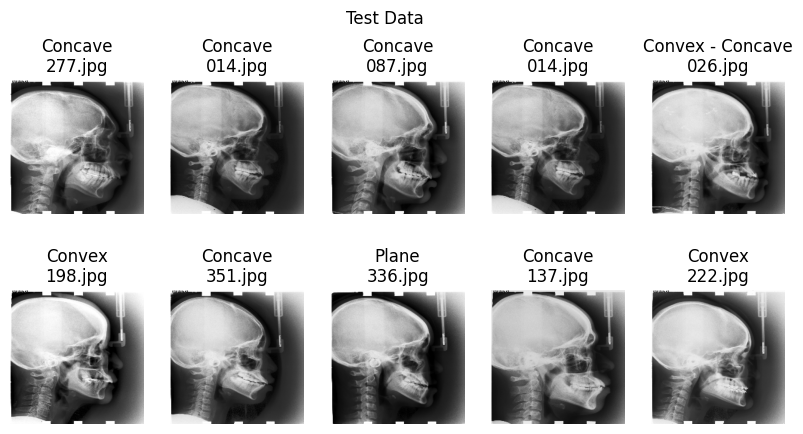

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 674ms/step - accuracy: 0.5030 - loss: 1.0069 - val_accuracy: 0.6000 - val_loss: 0.4101
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.5068 - loss: 0.3098 - val_accuracy: 0.6500 - val_loss: 0.1249
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.6074 - loss: 0.1309 - val_accuracy: 0.6167 - val_loss: 0.1118
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.6558 - loss: 0.1079 - val_accuracy: 0.7167 - val_loss: 0.0934
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.7111 - loss: 0.0836 - val_accuracy: 0.7667 - val_loss: 0.0679
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7562 - loss: 0.0679 - val_accuracy: 0.8667 - val_loss: 0.0559
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7904 - loss: 0.0589 - val_accuracy: 0.8833 - val_loss: 0.0509
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 188m

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, f1_score
import random

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/cepha400'

# Load CSV
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"
    return os.path.join(folder, image_filename), image_filename  # Return path and filename

# Prepare dataset: (Image, Tabular Features, Label, Image Name)
combined_data = []
for index, row in df.iterrows():
    image_id = row['data']
    label = row['type']
    upper_lip = row['upper_lip']
    lower_lip = row['lower_lip']

    image_path, image_filename = get_image_path(image_id, image_folder)
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        combined_data.append((img_array, [upper_lip, lower_lip], label, image_filename))
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -y_true * K.log(y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        return K.sum(weight * ce, axis=-1)
    return loss

# Convert tabular features to One-Hot Encoding
tabular_features = np.array([sample[1] for sample in combined_data])
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels
labels = [sample[2] for sample in combined_data]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Extract images and image names
images = np.array([sample[0] for sample in combined_data])
image_filenames = np.array([sample[3] for sample in combined_data])

# Create tuples with all mapped features
data_tuples = list(zip(images, tabular_features_encoded, labels_one_hot, image_filenames))

# Split dataset into Train (70%), Validation (15%), Test (15%)
train_data, temp_data = train_test_split(data_tuples, test_size=0.3, stratify=labels_encoded, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[np.argmax(sample[2]) for sample in temp_data], random_state=42)

# Visualization of images and labels after splitting
def visualize_data(data, title):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(data) - 1)
        img, _, label, img_name = data[idx]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{label_encoder.inverse_transform([np.argmax(label)])[0]}\n{img_name}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_data(train_data, "Training Data")
visualize_data(val_data, "Validation Data")
visualize_data(test_data, "Test Data")

# Unpack Train, Validation, Test sets correctly
X_train_img = np.array([sample[0] for sample in train_data])
X_train_tabular = np.array([sample[1] for sample in train_data])
y_train = np.array([sample[2] for sample in train_data])

X_val_img = np.array([sample[0] for sample in val_data])
X_val_tabular = np.array([sample[1] for sample in val_data])
y_val = np.array([sample[2] for sample in val_data])

X_test_img = np.array([sample[0] for sample in test_data])
X_test_tabular = np.array([sample[1] for sample in test_data])
y_test = np.array([sample[2] for sample in test_data])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images, augmented_tabular, augmented_labels = [], [], []

for i in range(len(X_train_img)):
    img = X_train_img[i].reshape((1,) + X_train_img[i].shape)
    tabular_features = X_train_tabular[i]
    label = y_train[i]

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(5):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_tabular.append(tabular_features)
        augmented_labels.append(label)

X_train_img = np.vstack([X_train_img, np.array(augmented_images)])
y_train = np.vstack([y_train, np.array(augmented_labels)])
X_train_tabular = np.vstack([X_train_tabular, np.array(augmented_tabular)])

# Build VGG16 multimodal model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False

x_img = Flatten()(vgg16.output)

# Tabular model
input_tabular = Input(shape=(X_train_tabular.shape[1],), name="tabular_input")
x_tabular = Dense(128, activation='relu')(input_tabular)

# Combine image and tabular features
combined = Concatenate()([x_img, x_tabular])
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=[vgg16.input, input_tabular], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=0.25, gamma=2.0),

    metrics=['accuracy']
)

# Train the model
history = model.fit(
    [X_train_img, X_train_tabular], y_train,
    validation_data=([X_val_img, X_val_tabular], y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


In [3]:
# Classification Report
y_pred = model.predict([X_test_img, X_test_tabular])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
                  precision    recall  f1-score   support

         Concave       1.00      1.00      1.00        37
          Convex       1.00      0.91      0.95        11
Convex - Concave       1.00      1.00      1.00         3
           Plane       0.90      1.00      0.95         9

        accuracy                           0.98        60
       macro avg       0.97      0.98      0.97        60
    weighted avg       0.98      0.98      0.98        60



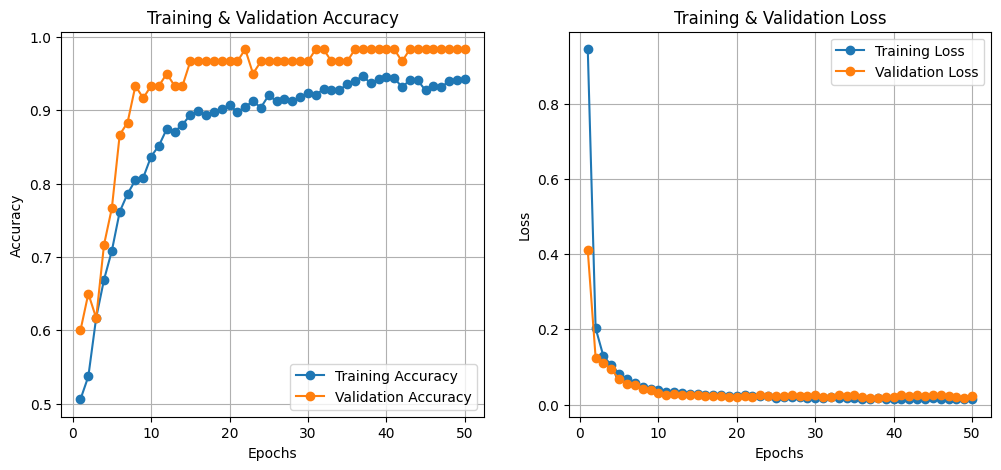

NameError: name 'accuracy' is not defined

In [4]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy and Loss
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Plot Test Metrics (Accuracy & F1-score)
def plot_test_results(accuracy, macro_f1, weighted_f1):
    metrics = ['Test Accuracy', 'Macro F1-score', 'Weighted F1-score']
    values = [accuracy, macro_f1, weighted_f1]

    plt.figure(figsize=(6, 5))
    plt.bar(metrics, values, color=['blue', 'green', 'orange'])
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.title("Test Results")
    plt.grid(axis='y')

    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12, fontweight='bold')

    plt.show()

# Call the function to plot test results
plot_test_results(accuracy, macro_f1, weighted_f1)

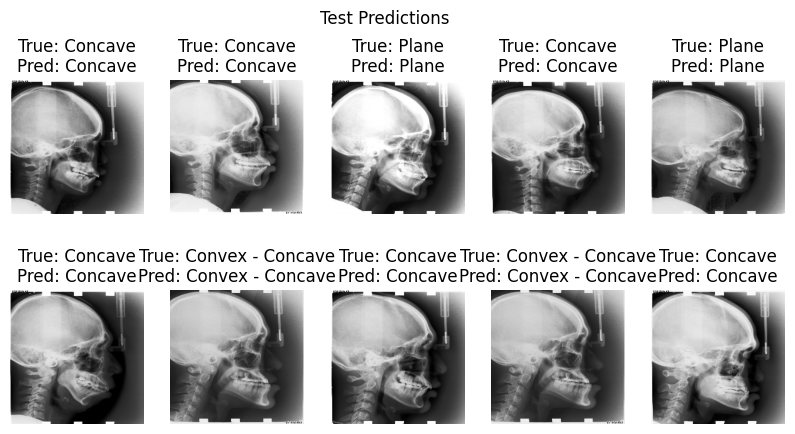

In [5]:
# Plot test results
def plot_test_results():
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(X_test_img) - 1)
        img = X_test_img[idx]
        true_label = label_encoder.inverse_transform([y_true_classes[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_classes[idx]])[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.suptitle("Test Predictions")
    plt.show()

plot_test_results()


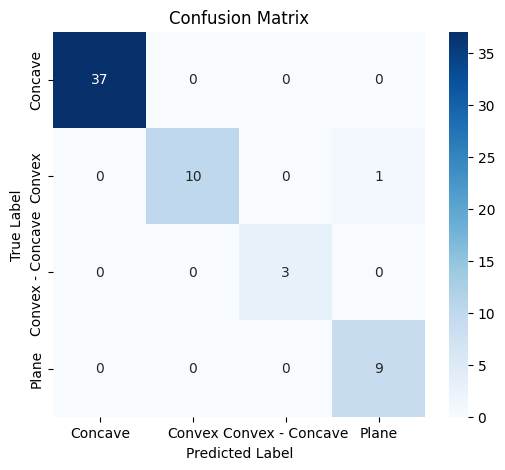

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

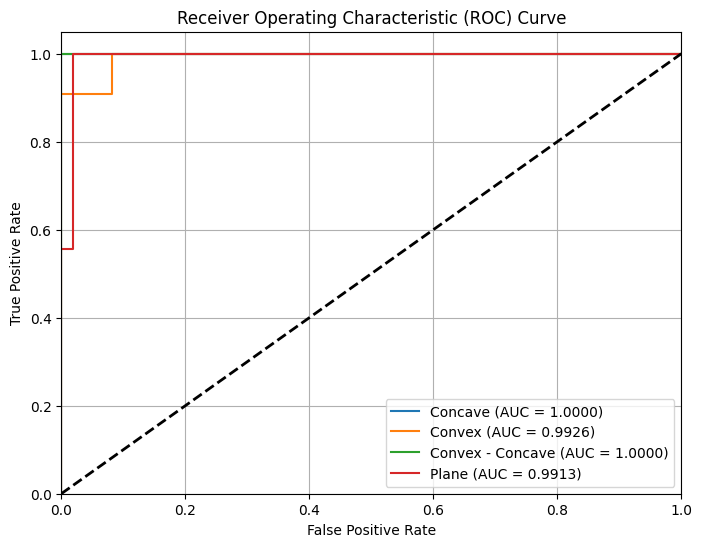

In [7]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

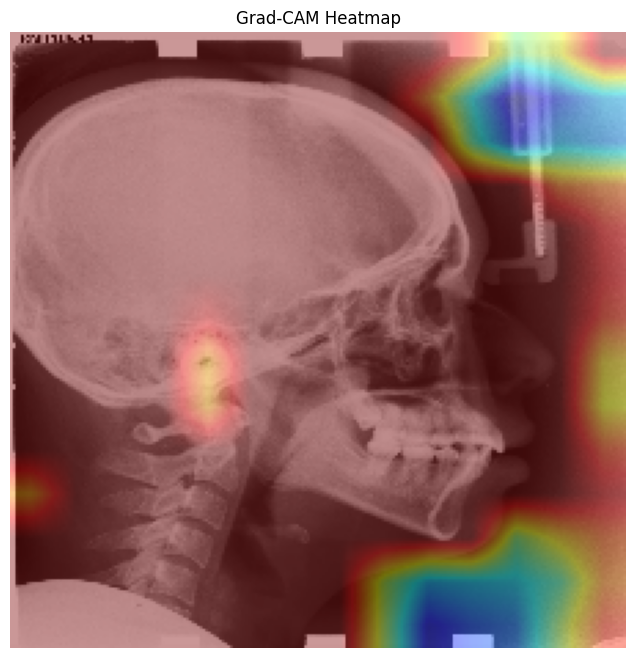

In [9]:
import cv2
import tensorflow.keras.backend as K

def grad_cam(model, image, tabular_data, layer_name):
    grad_model = Model(inputs=[model.input[0], model.input[1]],
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([np.expand_dims(image, axis=0), np.expand_dims(tabular_data, axis=0)])
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Choose an image and corresponding tabular data from the test set
sample_idx = 0
sample_image = X_test_img[sample_idx]
sample_tabular = X_test_tabular[sample_idx]

# Get Grad-CAM heatmap
heatmap = grad_cam(model, sample_image, sample_tabular, "block5_conv3")

# Overlay heatmap on the original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted((sample_image * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)

# Display the image with the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()
